# 📌 XGBoost Regression for SaO2 Prediction with Hyperparameter Tuning

This notebook trains an **XGBoost Regressor** model to predict **SaO2 (arterial blood gas oxygen saturation) from SpO2 (pulse oximeter reading)** and other patient-specific variables.

### **Steps in this Notebook:**
- Load and preprocess the data.
- Perform **hyperparameter tuning using GridSearchCV with 5-fold cross-validation**.
- Train the best XGBoost model.
- Evaluate the model using **MAE, MSE, RMSE, and R² score**.
- Visualize the results.

### **🚀 Let's get started!**

## 1️⃣ Import Required Libraries

In [6]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


## 2️⃣ Load the Dataset

The dataset is stored in a CSV file called `data.csv`.
Let's define a function `load_file()` to read the dataset.

In [8]:
def load_file(file_path):
    df = pd.read_csv(file_path)

    categorical_columns = df.select_dtypes(include=['object']).columns  # Detect object (string) columns

    for col in categorical_columns:
        if df[col].nunique() == 2:
            # Label Encoding for binary categorical columns
            df[col] = df[col].astype('category').cat.codes.astype(float)
        else:
            # One-Hot Encoding for multi-category columns
            df = pd.get_dummies(df, columns=[col], drop_first=True, dtype=float)

    # Ensure all data is float for compatibility with ML models
    df = df.astype(float)

    X = df.drop(columns=['SaO2'])  # Features
    y = df['SaO2']  # Target variable
    return X, y

DATA_SRC = 'data.csv'  # Path to dataset

## 3️⃣ Split Data into Training and Testing Sets

In [9]:
TEST_SIZE = 0.2  # 20% of the data for testing
X, y = load_file(DATA_SRC)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print(f'Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}')

Training Samples: 20187, Testing Samples: 5047


## 4️⃣ Hyperparameter Tuning with GridSearchCV

To find the best hyperparameters for XGBoost, we use **GridSearchCV** with **5-fold cross-validation**.

We will search for the best values for:
- `n_estimators` (Number of boosting rounds)
- `max_depth` (Tree depth)
- `learning_rate` (Step size for updates)
- `subsample` (Proportion of training data per tree)
- `colsample_bytree` (Proportion of features per tree)

This helps improve model performance and generalization.

In [10]:
# Define parameter grid
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [8, 16, 24],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5,  # 5-fold CV
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Best Parameters
print('Best Parameters:', grid_search.best_params_)

# Train final model with best parameters
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/timothy/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 24, 'n_estimators': 300, 'subsample': 0.8}


(This code may take a while to run)

## 5️⃣ Train the Optimized XGBoost Model

In [11]:
# Save the trained model
MODEL = 'optimized_model.json'
best_model.save_model(MODEL)

## 6️⃣ Make Predictions

In [12]:
y_pred = best_model.predict(X_test)

# Sample prediction-actual pairs
results = pd.DataFrame(y_pred, y_test)
results.head()

,0
SaO2,
88.8,88.335976
92.6,92.307381
95.4,93.773033
94.5,94.104919
71.8,72.002228


## 7️⃣ Evaluate Model Performance

In [13]:
def evaluate_model(y_test, y_pred):
    print('Model Performance:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred):.4f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')
    print(f'R² Score: {r2_score(y_test, y_pred):.4f}')

evaluate_model(y_test, y_pred)

Model Performance:
MAE: 0.5360
MSE: 0.8882
RMSE: 0.9424
R² Score: 0.9893


## 8️⃣ Visualizing actual SaO2 and SpO2 

/Users/timothy/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


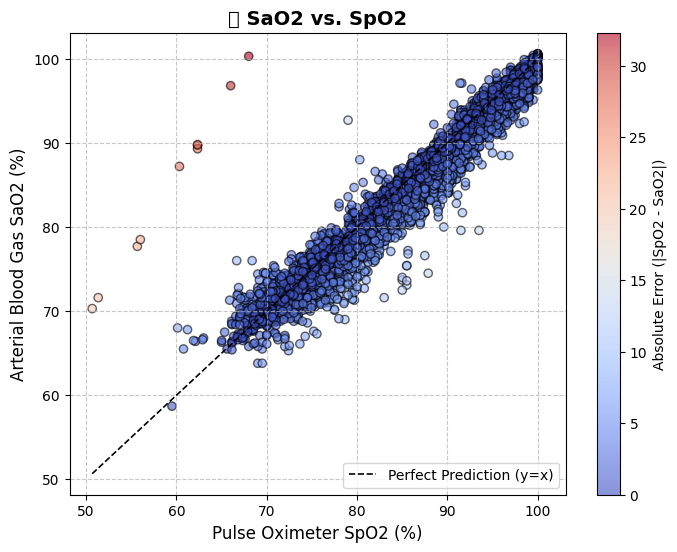

In [14]:
def plot_sao2_vs_spo2(X_test, y_test):
    """
    Scatter plot comparing SpO2 (x-axis) vs. SaO2 (y-axis).
    """
    plt.figure(figsize=(8, 6))  # Adjust figure size

    # Extract SpO2 values from X_test
    if 'SpO2' not in X_test.columns:
        raise ValueError("Column 'SpO2' not found in dataset. Ensure the correct feature is used.")

    spo2_values = X_test['SpO2']

    # Scatter plot with color gradient (error intensity)
    error = np.abs(spo2_values - y_test)  # Compute absolute error
    scatter = plt.scatter(spo2_values, y_test, c=error, cmap='coolwarm', alpha=0.6, edgecolors='k')

    # Add color bar to indicate error magnitude
    cbar = plt.colorbar(scatter)
    cbar.set_label("Absolute Error (|SpO2 - SaO2|)")

    # Diagonal reference line (perfect prediction line y = x)
    min_val, max_val = min(spo2_values), max(y_test)
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', linewidth=1.2, label="Perfect Prediction (y=x)")

    # Labels and title
    plt.xlabel("Pulse Oximeter SpO2 (%)", fontsize=12)
    plt.ylabel("Arterial Blood Gas SaO2 (%)", fontsize=12)
    plt.title("📊 SaO2 vs. SpO2", fontsize=14, fontweight="bold")

    # Enable grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

plot_sao2_vs_spo2(X_test, y_test)

## 9️⃣ Visualizing the predicted results

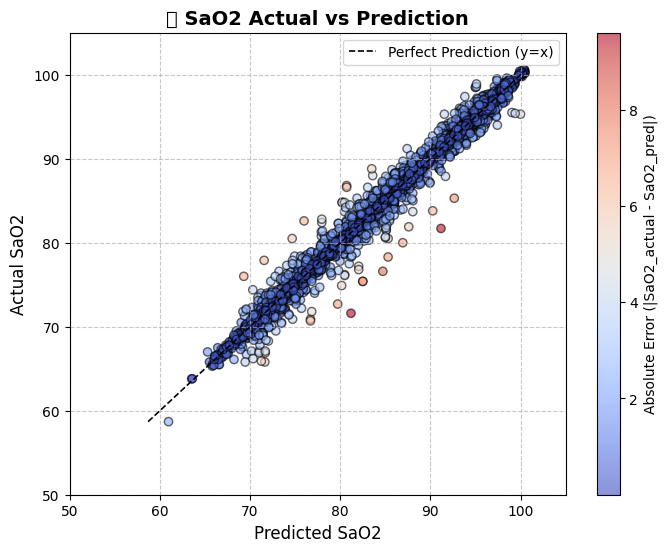

In [20]:
def plot_predictions(y_test, y_pred):
    """
    Beautified scatter plot comparing actual vs. predicted SaO2 values.
    """
    plt.figure(figsize=(8, 6))  # Adjust figure size
    plt.xlim(50, 105)  # Set X-axis from 50 to 100
    plt.ylim(50, 105)  # Set Y-axis from 50 to 100

    # Scatter plot with color gradient (error intensity)
    error = np.abs(y_test - y_pred)  # Compute absolute error
    scatter = plt.scatter(y_pred, y_test, c=error, cmap='coolwarm', alpha=0.6, edgecolors='k')

    # Add color bar to indicate error magnitude
    cbar = plt.colorbar(scatter)
    cbar.set_label("Absolute Error (|SaO2_actual - SaO2_pred|)")

    # Diagonal reference line (perfect prediction line y = x)
    min_val, max_val = min(y_test), max(y_test)
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black', linewidth=1.2, label="Perfect Prediction (y=x)")

    # Labels and title
    plt.xlabel("Predicted SaO2", fontsize=12)
    plt.ylabel("Actual SaO2", fontsize=12)
    plt.title("📊 SaO2 Actual vs Prediction", fontsize=14, fontweight="bold")

    # Enable grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

plot_predictions(y_test, y_pred)

## 🎯 Conclusion

- We successfully **performed hyperparameter tuning** using **GridSearchCV**.
- We trained the best **XGBoost Regressor** to predict **SaO2** from SpO2 and other patient parameters.
- The model's performance was evaluated using **MAE, MSE, RMSE, and R² score**.
- We visualized the **predicted vs. actual SaO2 values**.
